# Recurrent Neural Network vs Central Bank of Chile Economic Expectations Survey for Inflation Prediction

In this notebook I will test which model is better to predict Chile inflation. I will use the Diebold-Mariano test to get the results.

In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import csv
import datetime

In [2]:
def plot(x_data, y_data, x_label='Date', y_label='Value', format='-', title=None):
    plt.plot(x_data, y_data, format)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(title)
    plt.grid(True, color='0.80')

In [3]:
def create_window(series, window_size, forecast_horizon=0):
    output_data = series[window_size+forecast_horizon:]
    input_list = []
    for i in range(series.shape[0] - window_size - forecast_horizon):
        input_list.append(series[i:i + window_size])
    input_data = np.array(input_list)
    input_data = input_data.reshape(input_data.shape[0], input_data.shape[1], 1)
    output_data = output_data.reshape(output_data.shape[0], 1)
    return input_data, output_data

In [4]:
def neural_network_model(
    train_data, n_lags, hidden_units, epochs, learning_rate, forecast_horizon=0):
    input_data, output_data = create_window(train_data, n_lags, forecast_horizon=forecast_horizon)

    model = tf.keras.models.Sequential([
        tf.keras.layers.LSTM(hidden_units, input_shape=(n_lags, 1)),
        tf.keras.layers.Dense(1)
    ])

    model.compile(loss="mse", optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate))
    callback = tf.keras.callbacks.EarlyStopping(monitor="loss", patience=2)
    model.fit(input_data, output_data, epochs=epochs, verbose=0, shuffle=False, callbacks=[callback])
    return model

In [5]:
def calculate_mse(series_test, n_lags, model, forecast_horizon=0):
    forecasts = []
    input_data, output_data = create_window(series_test, n_lags, forecast_horizon=forecast_horizon)
    for data in input_data:
        data = data.reshape(1, data.shape[0], data.shape[1])
        prediction = model.predict(data)
        forecasts.append(prediction[0][0])
    squared_forecast_error = []
    for i in range(len(forecasts)):
        squared_forecast_error.append((output_data[i][0] - forecasts[i]) ** 2)
    return (sum(squared_forecast_error)) / len(squared_forecast_error)

In [6]:
def load_data(file_path, delimiter=',', load_column=1):
    period, variable = list(), list()
    with open(file_path, 'r') as csvfile:
        reader = csv.reader(csvfile, delimiter=delimiter)
        next(reader)
        for row in reader:
            if row[load_column] != '':
                variable.append(float(row[load_column]))
                year = int(row[0][:4])
                month = int(row[0][5:])
                period.append(datetime.date(year, month, 1))
    return period, variable

In [7]:
inflation_path = os.path.join('data', 'chile_inflation.csv')
eee_path = os.path.join('data', 'eee_inflation_forecast.csv')
infl_period, inflation = load_data(inflation_path, delimiter=';')
eee_11_period, eee_11_months = load_data(eee_path)

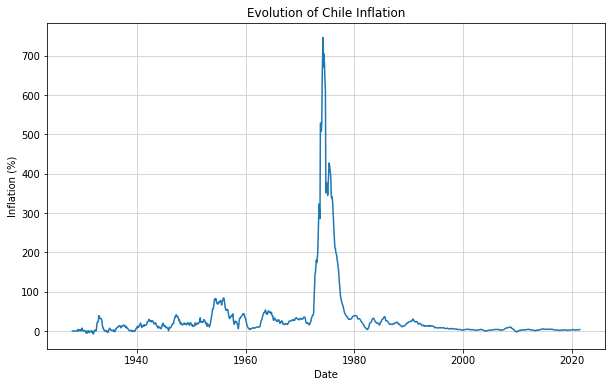

In [8]:
inflation = np.array(inflation)
infl_period = np.array(infl_period)
plt.figure(figsize=(10, 6))
plot(infl_period, inflation, y_label='Inflation (%)', title='Evolution of Chile Inflation')

---

## Economic Expectations Survey

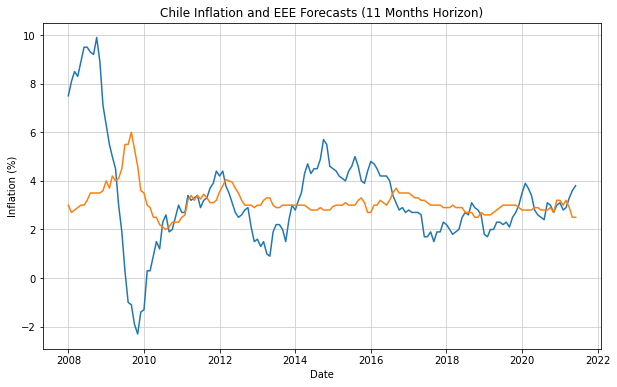

In [9]:
eee_11_months = np.array(eee_11_months)
eee_11_period = np.array(eee_11_period)
plt.figure(figsize=(10, 6))
plot(infl_period[-len(eee_11_months):], inflation[-len(eee_11_months):])
plot(eee_11_period, eee_11_months, y_label='Inflation (%)', title='Chile Inflation and EEE Forecasts (11 Months Horizon)')

---

# Neural Network Model – In-sample Forecast

The RNN model will be created using the following hyperparameters which corresponds to one of the optimal values obtained in the ```rnn_selection.ipynb``` notebook:
- Number of lags: 12
- Number of neurons in the LSTM layer: 80
- Number of epochs: 300
- Learning rate: 0.001

In [10]:
lag, unit, epoch, learning_rate = 24, 80, 300, 0.001
horizon = 11
forecasts = []

first_period = np.where(infl_period == datetime.date(2007, 1, 1))[0][0] # January 2007
for i in range(first_period + 1, len(infl_period)):
    inflation_train = inflation[:i]
    model = neural_network_model(
        inflation_train, lag, unit, epoch, learning_rate, forecast_horizon=horizon)
    forecast_data = inflation[i - lag:i]
    forecast_data = forecast_data.reshape(1, forecast_data.shape[0], 1)
    prediction = model.predict(forecast_data)
    forecasts.append(prediction[0][0])
forecasts = forecasts[:-lag] # The last observations are out-of-sample forecasts

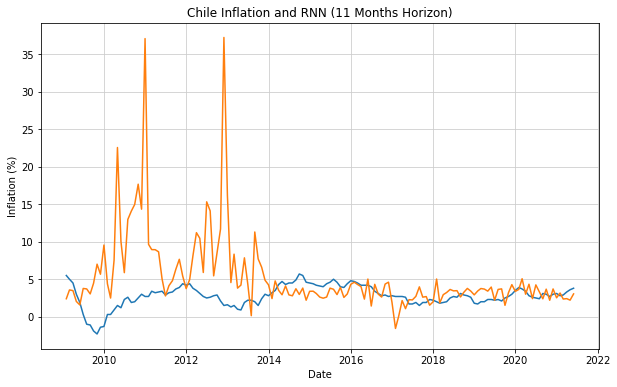

In [11]:
plt.figure(figsize=(10, 6))
plot(infl_period[-len(forecasts):], inflation[-len(forecasts):])
plot(infl_period[-len(forecasts):], forecasts, y_label='Inflation (%)', title='Chile Inflation and RNN (11 Months Horizon)')

---

## Diebold and Mariano Test

In [13]:
from scipy.stats import ttest_1samp

error_difference = []
for i in range(len(forecasts)):
    error_difference.append(eee_11_months[i] - forecasts[i])

t_test, p_value = ttest_1samp(error_difference, 0)

print('\tDiebold-Mariano test\n')
print(f't-test: {round(t_test, 2)}')
print(f'p-value: {round(p_value, 2)}')

	Diebold-Mariano test

t-test: -5.16
p-value: 0.0
